In [ ]:
'''
【项目04】  视频网站数据清洗整理和结论研究

作业要求：
1、数据清洗 - 去除空值
要求：创建函数
提示：fillna方法填充缺失数据，注意inplace参数

2、数据清洗 - 时间标签转化
要求：
① 将时间字段改为时间标签
② 创建函数
提示：
需要将中文日期转化为非中文日期，例如 2016年5月24日 → 2016.5.24

3、问题1 分析出不同导演电影的好评率，并筛选出TOP20
要求：
① 计算统计出不同导演的好评率，不要求创建函数
② 通过多系列柱状图，做图表可视化
提示：
① 好评率 = 好评数 / 评分人数
② 可自己设定图表风格

4、问题2 统计分析2001-2016年每年评影人数总量
要求：
① 计算统计出2001-2016年每年评影人数总量，不要求创建函数
② 通过面积图，做图表可视化，分析每年人数总量变化规律
③ 验证是否有异常值（极度异常）
④ 创建函数分析出数据外限最大最小值）
⑤ 筛选查看异常值 → 是否异常值就是每年的热门电影？
提示：
① 通过箱型图验证异常值情况
② 通过quantile(q=0.5)方法，得到四分位数
③ IQR=Q3-Q1
④ 外限：最大值区间Q3+3IQR,最小值区间Q1-3IQR （IQR=Q3-Q1）
⑤ 可自己设定图表风格

'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def DataCleanse(data):
    data_cols = data.columns
    for i in data_cols:
        if data[i].dtype == 'object':
            data[i].fillna('缺失数据', inplace = True)
        else:
            data[i].fillna(0, inplace = True)
    return(data)

def time_switch(datatime,col_name):
    datatime[col_name] = datatime[col_name].str.replace('年','.')
    datatime[col_name] = datatime[col_name].str.replace('月','.')
    datatime[col_name] = datatime[col_name].str.replace('日','')
    datatime[col_name] = pd.to_datetime(datatime[col_name])
    return (datatime)

def unusual_value(dataframe,col):
    q1 = dataframe[col].quantile(q=0.25)
    q3 = dataframe[col].quantile(q=0.75)
    iqr = q3 -q1
    tmax = q3 + 3*iqr
    tmin = q1 - 3*iqr
    return(tmax,tmin)

iqiyi_data= pd.read_csv('爱奇艺视频数据.csv',engine='python',encoding='utf8')
iqiyi_data_Cleaned = DataCleanse(iqiyi_data)

iqiyi_data_Cleaned = time_switch(iqiyi_data_Cleaned,'数据获取日期')






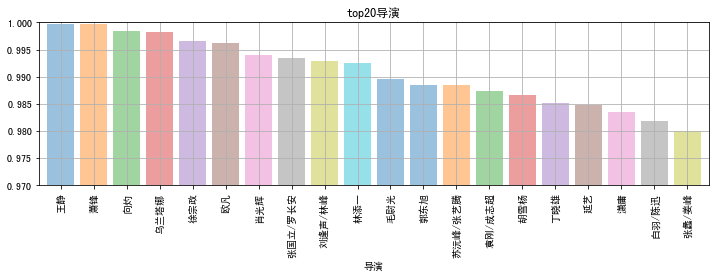

In [3]:
iqiyi_data_GEval = iqiyi_data_Cleaned.groupby('导演')[['好评数','评分人数']].sum()

iqiyi_data_GEval['好评率'] = iqiyi_data_GEval['好评数']/iqiyi_data_GEval['评分人数']
iqiyi_top20 = iqiyi_data_GEval.sort_values('好评率',ascending=False)[:20]
iqiyi_top20['好评率'].plot(kind = 'bar',ylim = [0.97,1],alpha = 0.45,width = 0.8,grid = True ,
                        figsize = (12,3),title = 'top20导演',linestyle='-.',linewidth = "3")

In [47]:
# 4、问题2 统计分析2001-2016年每年评影人数总量

# 要求：

# ① 计算统计出2001-2016年每年评影人数总量，不要求创建函数

# ② 通过面积图，做图表可视化，分析每年人数总量变化规律

# ③ 验证是否有异常值（极度异常）

# ④ 创建函数分析出数据外限最大最小值）

# ⑤ 筛选查看异常值 → 是否异常值就是每年的热门电影？

# 提示：

# ① 通过箱型图验证异常值情况

# ② 通过quantile(q=0.5)方法，得到四分位数

# ③ IQR=Q3-Q1

# ④ 外限：最大值区间Q3+3IQR,最小值区间Q1-3IQR （IQR=Q3-Q1）

# ⑤ 可自己设定图表风格

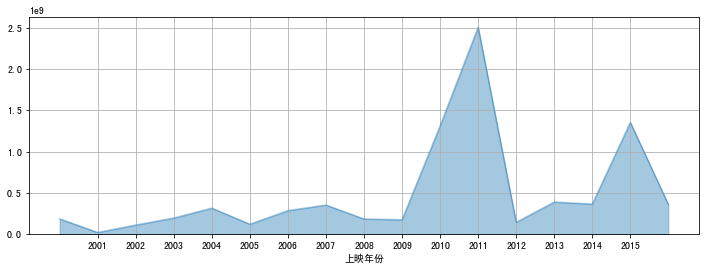

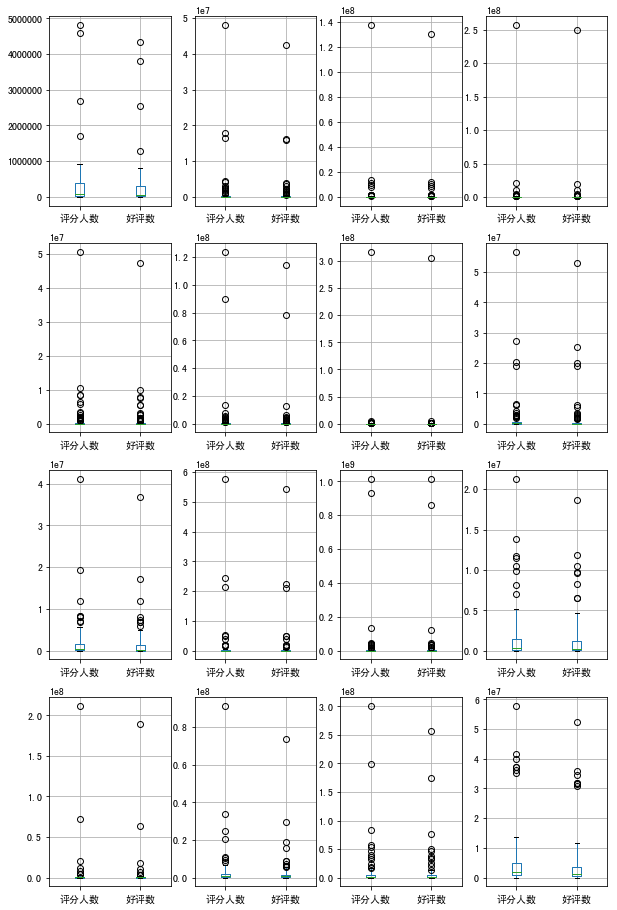

In [4]:
iqiyi_data_deal = iqiyi_data_Cleaned[['导演','上映年份','整理后剧名']].drop_duplicates()
iqiyi_data_deal = iqiyi_data_deal[iqiyi_data_deal['上映年份']!=0]
iqiyi_data_deal = iqiyi_data_deal[iqiyi_data_deal['导演']!='缺失数据']

iqiyi_data_deal_cum = iqiyi_data_Cleaned.groupby('整理后剧名').sum()[['评分人数','好评数']]
iqiyi_data_deal_hub =pd.merge(iqiyi_data_deal,iqiyi_data_deal_cum,left_on = '整理后剧名',right_index=True)

iqiyi_data_deal_year = iqiyi_data_deal_hub.groupby('上映年份').sum()[['评分人数','好评数']]


fig =plt.figure(num = 1)
iqiyi_data_deal_year['评分人数'].loc[2000:].plot.area(figsize=(12,4),grid = True,alpha = 0.4)
plt.xticks(range(2001,2016))

fig,axes = plt.subplots(4,4,figsize = (10,16))
start = 2001
for i in range(4):
    for j in range(4):
        data = iqiyi_data_deal_hub[iqiyi_data_deal_hub['上映年份'] == start]
        data[['评分人数','好评数']].boxplot(whis = 3,return_type = 'dict',ax =axes[i,j])
        start = start+1


In [5]:
for i in range(2001,2016):
    datayear = iqiyi_data_deal_hub[iqiyi_data_deal_hub['上映年份']== i]
    print('%i年有%i条数据'%(i,len(datayear)))
    t = unusual_value(datayear,'评分人数')
    print(datayear[datayear['评分人数']>t[0]])
    print('\n')

2001年有49条数据
           导演    上映年份   整理后剧名       评分人数        好评数
1027       英达  2001.0   东北1家人  2674339.0  2550233.0
1338      王冀邢  2001.0      黑冰  1703364.0  1278592.0
1863      胡明凯  2001.0  少年包青天2  4809919.0  4335522.0
1972  陈家林、刘大印  2001.0    康熙王朝  4589462.0  3811875.0


2002年有74条数据
          导演    上映年份       整理后剧名        评分人数         好评数
69       赵宝刚  2002.0  拿什么拯救你我的爱人   2184294.0   1954774.0
670      梁德龙  2002.0       少年张3丰  48030057.0  42450999.0
179      王文杰  2002.0         大染坊   1213903.0    943441.0
542      高力强  2002.0       乌龙闯情关  17787335.0  16282770.0
560      胡雪杨  2002.0        白领公寓   1056247.0   1042170.0
705      刘家成  2002.0    铁齿铜牙纪晓岚2   4116280.0   3598471.0
711      张国立  2002.0    康熙微服私访记4   2430093.0   2139569.0
978       欧凡  2002.0      我的淘气天使   3100421.0   3088701.0
1026      英达  2002.0     东北1家人续集    832767.0    783944.0
1118     王重光  2002.0         半生缘   1788765.0   1593117.0
1267   马骁/赵镭  2002.0        乾隆王朝   1807823.0   1519044.0
1533      沈庄  2002.0        无敌

In [6]:
# from matplotlib.font_manager import _rebuild
# _rebuild()
# # 防止中文乱码问题
# # matplotlib不会每次启动时都重新扫描所有的字体文件并创建字体索引列表，
# # 因此在复制完字体文件之后，需要运行下面的语句以重新创建字体索引列表
# from matplotlib.font_manager import _rebuild
# _rebuild()
# #防止中文乱码问题
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus']=False